*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/fall23/notebooks/module05_04_classifier_accuracy.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict

# Measuring classifier accuracy

There is more to measuring classifier accuracy than using the standard accuracy measure defined as the fraction of examples that are classified correctly.  There are many situations in which this is not the right way of measuring accuracy.  One example is when dealing with data that is imbalanced, ie. when one class has many more examples than the other.

### The confusion matrix

Before introducing new measures of accuracy we will explore the **confusion matrix**.  We will do so using the iris dataset:

In [3]:
from sklearn import datasets
iris = datasets.load_iris()
X=iris.data
y=iris.target
print(X.shape, y.shape)

(150, 4) (150,)


Let's apply a nearest neighbor classifier to the data:

In [15]:
classifier = KNeighborsClassifier(n_neighbors=1)
y_pred = cross_val_predict(classifier, X, y, cv=5)
np.mean(y==y_pred)

0.96

In [22]:
from sklearn import svm
classifier = svm.SVC(kernel="rbf", gamma=0.01)
y_pred = cross_val_predict(classifier, X, y, cv=5)
np.mean(y==y_pred)

0.9333333333333333

While knowing the level of accuracy of the classifier, you might want to dig in a little deeper.
For example, you might ask:

* What kinds of errors does the classifier tend to make
* Which classes tend to be confused

All this information is captured by the **confusion matrix**.  To illustrate the concept, here is the confusion matrix for the predictions we just made:

In [23]:
from sklearn.metrics import confusion_matrix
print (iris.target_names)
matrix = confusion_matrix(y, y_pred)
print (matrix)

['setosa' 'versicolor' 'virginica']
[[50  0  0]
 [ 0 46  4]
 [ 0  6 44]]


Scikit-learn has a function called [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn-metrics-confusionmatrixdisplay) for creating a nicer visualization of the confusion matrix:

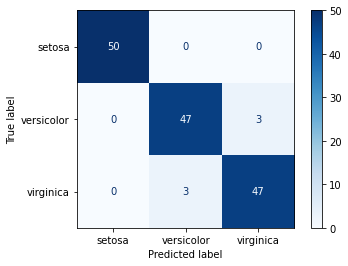

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay 

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, 
                              display_labels=iris.target_names)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

Note that scikit-learn uses a convention that is different than other sources for labeling the axes of the confusion matrix (see e.g. the [wikipedia article on the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)).

#### Definition of the confusion matrix

Rows of the confusion matrix correspond to the true labels, while columns correspond to the predicted labels.
The elements of the matrix in a given row quantify how predictions are distributed across the different classes.
More formally, element $i, j$ in the matrix is the number of examples from class $i$ predicted to be in class $j$.
As its name suggests, it tells us where the classifier tends to be confused.

#### Question

* How do you compute the accuracy of the classifier from the confusion matrix?

### What gets confused with what

The confusion matrix provides more information than accuracy:  for this dataset it tells us that the classifier has some difficulty distinguishing between iris-versicolor and iris-virginica, while iris-setosa is perfectly distinguishable from the other two classes.
This makes sense in view of the following visualization of the data that demonstrates the overlap between iris-versicolor and iris-virginica:

In [7]:
def scatter_with_legend(X, y, ax, class_names) :
    colors = ['ob', 'or', 'oc']
    for c in range(len(class_names)):
        idx = (y==c)
        ax.plot(X[idx,0], X[idx,1], colors[c], 
                label = class_names[c], alpha=0.5)
    ax.legend()

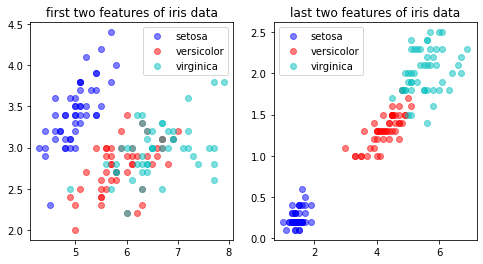

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
scatter_with_legend(X[:,[0, 1]], y, ax1, iris.target_names)
scatter_with_legend(X[:,[2, 3]], y, ax2, iris.target_names)
ax1.set_title('first two features of iris data')
ax2.set_title('last two features of iris data');

### The confusion matrix for binary classification problems

For binary classification problems we have special terminology that we will present next.
Let's take a look at a confusion matrix for the breast cancer prediction dataset:

In [9]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

X = data.data
y = data.target
print('number of examples ', len(y))
print('number of features ', len(X[0]))               
print(data.target_names)

number of examples  569
number of features  30
['malignant' 'benign']


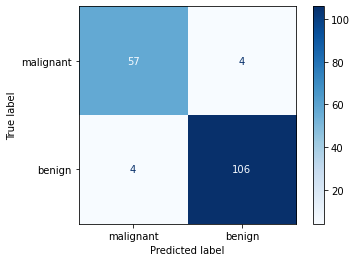

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=11)

classifier = SVC(C=1000, class_weight='balanced')

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, 
                              display_labels=data.target_names)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, 
          cmap=plt.cm.Blues, 
          values_format="d");

In the case of a binary classification problem the entries in the confusion matrix have names:

| True / Predicted | positive            | negative            |
| :--------------- |:------------------- | :------------------ |
| **positive**     | true positive (TP)  | false negative (FN) |
| **negative**     | false positive (FP) | true negative (TN)  |


Let's define $\mathrm{P} = \mathrm{TP} + \mathrm{FN}$ and $\mathrm{N} = \mathrm{FP} + \mathrm{TN}$.
In terms of the entries of the confusion matrix we can define additional measures of accuracy that are commonly used in machine learning:


**Precision:**

$$
 \mathrm {precision} =\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FP} }
$$

Precision tells us how accurate are the positive predictions, i.e. when the classifier makes a positive prediction, how likely it is to be correct.


**Recall** (true positive rate):

$$
\mathrm {recall} =\frac {\mathrm {TP} }{\mathrm {P} }
=\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }
$$

Recall tells us what fraction of the positive examples our classifier is able to classify correctly.
The true negative rate, or specifcity is defined analogously as $\mathrm{TN} / \mathrm{N}$.


A good classifier should have both high precision and high recall.

#### Exercise

Compute precision and recall for the breast cancer prediction task.

We are all familiar with accuracy.  We can express it using the confusion matrix:

**Accuracy**:

$$
\mathrm{accuracy}= 
\frac{\mathrm{TP} + \mathrm{TN}}{\mathrm{P + N}}
$$

Earlier in the course we pointed out that the standard measure of accuracy is not a good indication of  success for data that is imbalanced.  In particular, we have seen that the majority classifier has very high accuracy for imbalanced data.  Balanced accuracy addresses this shortcoming.

**Balanced accuracy** is the mean of recall (true positive rate) and specificity (true negative rate):

$$
\mathrm{balanced\!-\!accuracy}= 
\frac{1}{2}\left( \frac{\mathrm{TP}}{\mathrm{P}} + \frac{\mathrm{TN}}{\mathrm{N}}  \right)
$$

The **F1 score** is the harmonic mean of precision and recall:

$$
\mathrm {F} _{1}=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}
$$

The F1 score is commonly used in the field of information retrieval to measure performance in search, text categorization, and other natural language processing applications.
The F1 score focuses on true positives and does not take into account into account true negatives.  Its focus is on how well a classifier is performing in retrieving relevant items.

### Exercises

* Recall and precision are competing goals.  Give examples of applications where high precision is more important than high recall.  Similarly, think of applications where high recall is more important.
* What is the balanced accuracy of the majority classifier?
* Show that when the data has an equal number of positive and negative examples, balanced accuracy is equal to accuracy.

## Rank Based Evaluation

Most of the classifiers we have looked at so far produce some measure of confidence in the prediction (the so-called *decision function*).  For linear classifiers it indicates a distance from the separating hyperplane.  For a KNN classifier it can be an indication of the strength of the majority voting for a given example.
Now let's consider the situation where our classifier is providing us a list of items that are relevant.  For example, our classifier might give us documents that are relevant to a given concept, e.g. documents that discuss a certain topic of interest.  As a user, we will first consider those items that are high confidence, and as such, we are more interested in the precision of those high confidence items.
So we will look at how precision varies as you go down the list of predictions, generating what's known as the **precision-recall curve**.

In [11]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

X = data.data[:,8:10]
y = data.target
print('number of examples ', len(y))
print('number of features ', len(X[0]))
num_examples, num_features = X.shape
rng = np.random.default_rng(seed=42)

# if you want to make the problem more challenging, uncomment the 
# following statement:
#X = np.concatenate([X, 
#                    rng.normal(size=(num_examples, 10000))], 
#                   axis=1)

print('new number of examples ', len(y))
print('new number of features ', len(X[0]))                    
print(data.target_names)

number of examples  569
number of features  2
new number of examples  569
new number of features  2
['malignant' 'benign']


In [12]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=11)

classifier = SVC(C=1000)
classifier.fit(X_train, y_train)

f_pred = classifier.decision_function(X_test)

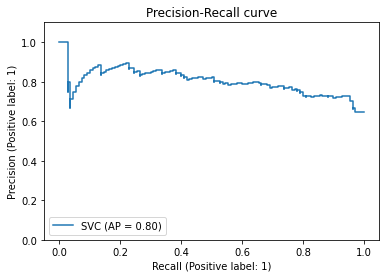

In [13]:
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_predictions(y_test, f_pred, 
                                                  name="SVC")
display.ax_.set_title("Precision-Recall curve");
display.ax_.set_ylim([0,1.1]);

The area under the precision-recall curve (AUC-PR) is a measure of a classifier's accuracy.  A perfect classifier will have an AUC-PR equal to 1.  Roughly speaking, the AUC-PR is an average over precision for all levels of recall, although there are slight differences due to implementation details.  Average precision is shown in the legend of the curve above and next we compute the area under the precision recall curve:

In [14]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precision, recall, thresholds = precision_recall_curve(y_test, f_pred)

auc(recall, precision)

0.7997063618256229

Another rank-based evaluation score uses the **Receiver-Operator Characteristic curve**, aka the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), which is also implemented in scikit-learn (see [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) ).

### Conclusions

Quantifying classifier accuracy is extremely important, and different problems benefit from different ways of measuring it, depending on the goals of the end-user.  The list of measures we discussed here is far from being complete, even for binary classification problems.  Multi-class, multi-label and other types of classification problems require specialized measures that we also did not discuss.